# Import Packages

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn, optim
from torch.nn import functional as F
# import dataloader from torch
#import dataset
# import toTesor
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import sys
from PIL import Image
import cv2
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

from dataset import TrainDatasetFromFolder
from model import Generator, Discriminator, GeneratorLoss
from tqdm import tqdm
from torch.autograd import Variable

c:\Users\Suren\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
UPSCALE_FACTOR = 4
CROP_SIZE = 24
N_EPOCHS = 5

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [5]:
train_set = TrainDatasetFromFolder("data/original/train/", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR, inter=Image.NEAREST)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

C:\Users\Suren\AppData\Local\Temp\ipykernel_56416\393351053.py:2: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  upscale_factor=UPSCALE_FACTOR, inter=Image.NEAREST)
C:\Users\Suren\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [6]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

generator_criterion = GeneratorLoss()

generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

C:\Users\Suren\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Suren\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [8]:
def train():
    global netG, netD, optimizerG, optimizerD, generator_criterion, N_EPOCHS, trainloader, results
    for epoch in range(1, N_EPOCHS + 1):
        train_bar = tqdm(trainloader)
        running_results = {'batch_sizes':0, 'd_loss':0,
                            "g_loss":0, "d_score":0, "g_score":0}

        netG.train()
        netD.train()
        for data, target in train_bar:
            g_update_first = True
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size

            real_img = Variable(target)
            real_img = real_img.to(device)
            z = Variable(data)
            z = z.to(device)

            ## Update Discriminator ##
            fake_img = netG(z)
            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph = True)
            optimizerD.step()
            
            ## Now update Generator
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            netG.zero_grad()
            g_loss = generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()

            fake_img = netG(z)
            fake_out = netD(fake_img).mean()

            optimizerG.step()

            running_results['g_loss'] += g_loss.item() * batch_size
            running_results['d_loss'] += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += real_out.item() * batch_size

            ## Updating the progress bar
            train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
                epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']
            ))
            results["d_loss"].append(running_results['d_loss'] / running_results['batch_sizes'])
            results["g_loss"].append(running_results['g_loss'] / running_results['batch_sizes'])
            results["d_score"].append(running_results['d_score'] / running_results['batch_sizes'])
            results["g_score"].append(running_results['g_score'] / running_results['batch_sizes'])

        netG.eval()
    return results, netG, netD

In [9]:
res, netG, netD = train()

[1/5] Loss_D: 0.3939 Loss_G: 0.0253 D(x): 0.7876 D(G(z)): 0.7876: 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]
[2/5] Loss_D: 0.0181 Loss_G: 0.0128 D(x): 0.9907 D(G(z)): 0.9907: 100%|██████████| 56/56 [00:36<00:00,  1.52it/s]
[3/5] Loss_D: 0.2117 Loss_G: 0.0102 D(x): 0.8986 D(G(z)): 0.8986: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s]
[4/5] Loss_D: 0.0893 Loss_G: 0.0096 D(x): 0.9509 D(G(z)): 0.9509: 100%|██████████| 56/56 [00:35<00:00,  1.58it/s]
[5/5] Loss_D: 0.0276 Loss_G: 0.0089 D(x): 0.9819 D(G(z)): 0.9819: 100%|██████████| 56/56 [00:34<00:00,  1.62it/s]


# Predicting

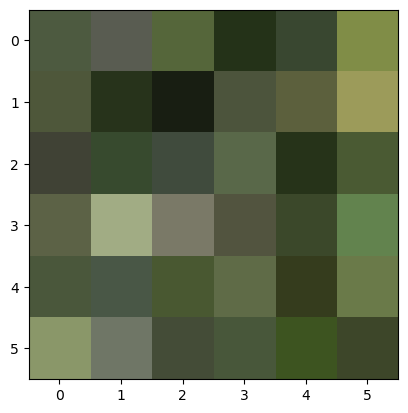

In [10]:
low_res, high_res = train_set[0]

plt.imshow(low_res.permute(1, 2, 0))
plt.show()

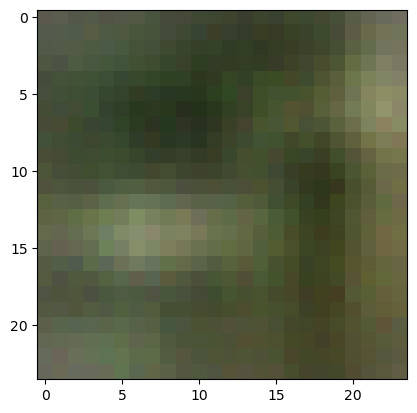

In [11]:
# predict the outout using netD and netG
predicted = netG(low_res.unsqueeze(0).to(device))

plt.imshow(predicted.squeeze(0).detach().cpu().permute(1, 2, 0))
plt.show()

torch.Size([1, 3, 96, 96])


C:\Users\Suren\AppData\Local\Temp\ipykernel_56416\3498879413.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((24, 24), Image.BICUBIC)


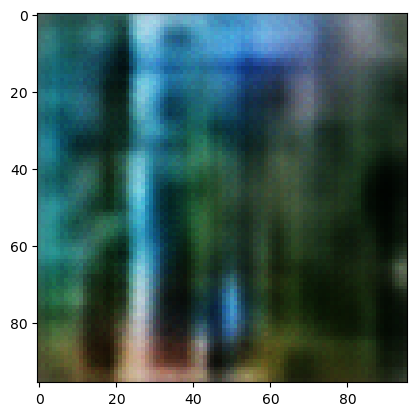

In [12]:
# select an image from data/original/train

img = Image.open("data/original/train/image_0.jpg")
# resize the image to 96x96
img = img.resize((24, 24), Image.BICUBIC)

# convert to tensor
img = ToTensor()(img)

# predict

img = torch.unsqueeze(img, 0)
img = img.to(device)
predicted = netG(img)

#  show the image
print(predicted.shape)

plt.imshow(predicted.squeeze(0).detach().cpu().permute(1, 2, 0))
plt.show()

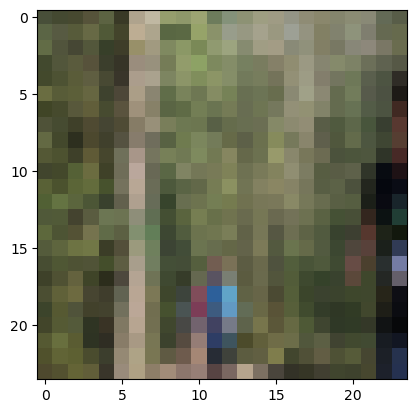

In [13]:
img = Image.open("data/original/train/image_0.jpg")
# resize the image to 96x96
img = img.resize((24, 24))

# plot the image
plt.imshow(img)
plt.show()